<a href="https://colab.research.google.com/github/mrusamarasheed9/final-project/blob/main/tcchurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Important and required Libraries
!pip install missingno
!pip install scikit-learn
!pip install xgboost
!pip install lightgbm

In [2]:
# Install Important and required Libraries
!pip install catboost
!pip install pydotplus
!pip install skompiler


In [3]:
!pip install numpy==1.26.4

In [4]:
#!pip install numpy==1.24.4

In [5]:
#Import the important and required Libraries and Funcations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import joblib
import graphviz
import pydotplus
import plotly.graph_objects as go
from scipy import stats
from datetime import date
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from skompiler import skompile
import warnings
warnings.simplefilter(action="ignore")

In [6]:
from google.colab import files
import pandas as pd
uploaded = files.upload()
df = pd.read_csv('TCC.csv')

Saving TCC.csv to TCC.csv


**Columns and Rows Information Print Settings** **bold text**

In [7]:
#Ensures that all columns of a Pandas DataFrame are displayed when printed
pd.set_option('display.max_columns', None)
#Sets the display width to 1000 characters
pd.set_option('display.width', 1000)
#Ensures that all rows of the DataFrame are displayed
pd.set_option('display.max_rows', None)
#Formats all floating-point numbers to display three decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

**Exploratory Data Analysis (EDA):** Perform an (EDA)

In [8]:
def check_df(dataframe, head=5):
#Displays the Dataset info of the Dataset, i.e., the number of rows and columns
    print("Dataset Info")
    print(dataframe.shape)
#Shows the data types of each columns
    print("Data Types")
    print(dataframe.dtypes)
#Prints the first Columns Head
    print("Veriables Head")
    print(dataframe.head(head))
#Prints the Columns Tails
    print("Veriables Tail")
    print(dataframe.tail(head))
#Displays the number of missing (NaN) values in each columns
    print("Print NA Values")
    print(dataframe.isnull().sum())
#Computes and prints quantiles
   # print("Print Quantiles")
   # print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
check_df(df)

Dataset Info
(7043, 21)
Data Types
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
Veriables Head
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges Churn
0  7590-VHVEG  Female              0     Yes         No  

**Handling Data Type Conversion**

In [9]:
# Changed the type of the TotalCharges variable.

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# Changed the type of the SeniorCitizen variable.

df["SeniorCitizen"] = df["SeniorCitizen"].astype("O")

# Changed the representation of the Churn variable in the dataset from "Yes" and "No" to 1 and 0.

df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

In [10]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Classifying Variables as Numeric or Categorical**

* Returns the categorical, numeric and categorical veriables but cardinal variables in the data set.
* Categorical variables includes both categorical variables with numeric appearance

In [12]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]
#Prints the number of rows (observations)
    print(f"Observations: {dataframe.shape[0]}")
#Prints the number of columns (variables)
    print(f"Variables: {dataframe.shape[1]}")
#Prints the number of categorical variables
    print(f'cat_cols: {len(cat_cols)}')
#Prints the number of numerical variables
    print(f'num_cols: {len(num_cols)}')
#Prints the number of cardinal categorical variables
    print(f'cat_but_car: {len(cat_but_car)}')
#Prints the number of numerical-looking categorical variables
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [13]:
#Detects different types of columns in a Pandas DataFrame
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)
#column that hold categorical data
cat_cols
#column that hold numerical data
num_cols
#column that appear categorical but have too many unique values
cat_but_car
#column that are stored as numbers but behave like categories
num_but_cat

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1


['Churn']

**Catagorical Veriables Distribution Analysis**

        gender  Ratio
gender               
Male      3555 50.476
Female    3488 49.524
Distribution of gender


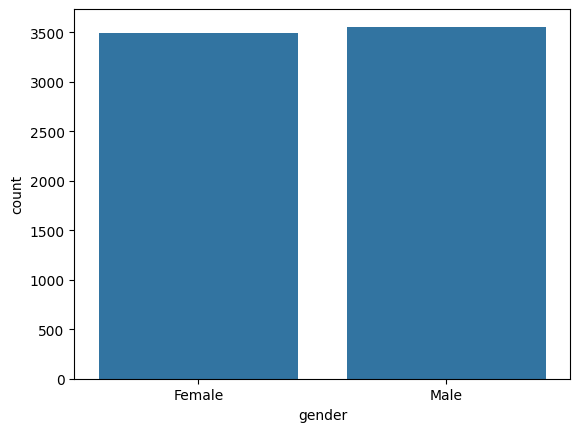

               SeniorCitizen  Ratio
SeniorCitizen                      
0                       5901 83.785
1                       1142 16.215
Distribution of SeniorCitizen


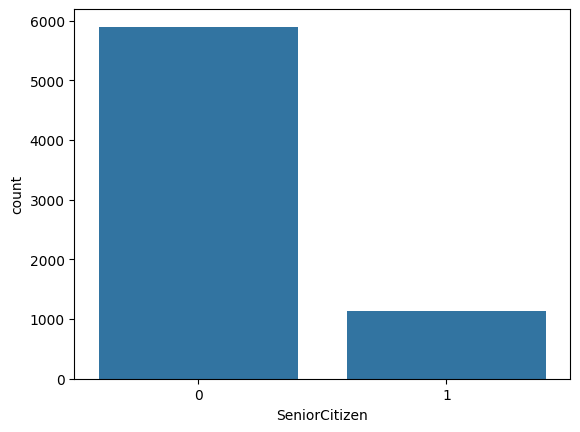

         Partner  Ratio
Partner                
No          3641 51.697
Yes         3402 48.303
Distribution of Partner


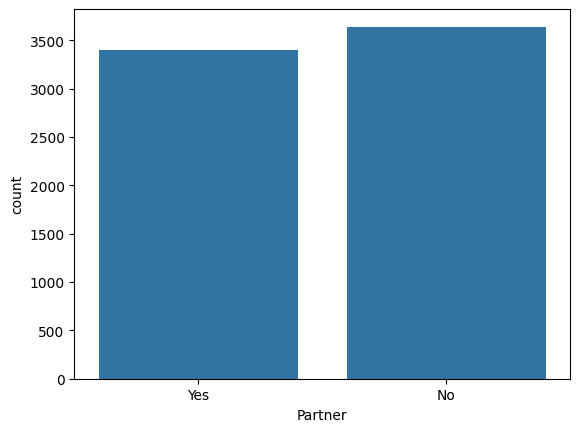

            Dependents  Ratio
Dependents                   
No                4933 70.041
Yes               2110 29.959
Distribution of Dependents


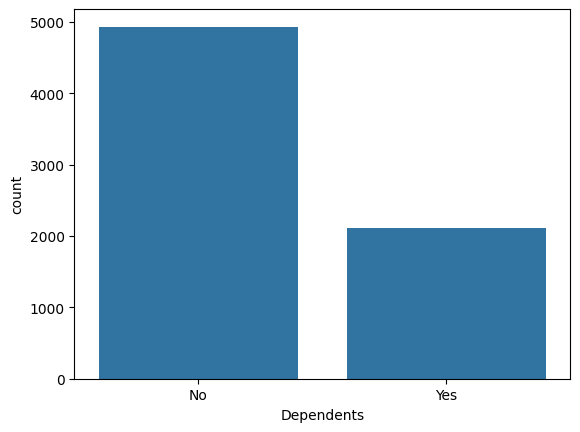

              PhoneService  Ratio
PhoneService                     
Yes                   6361 90.317
No                     682  9.683
Distribution of PhoneService


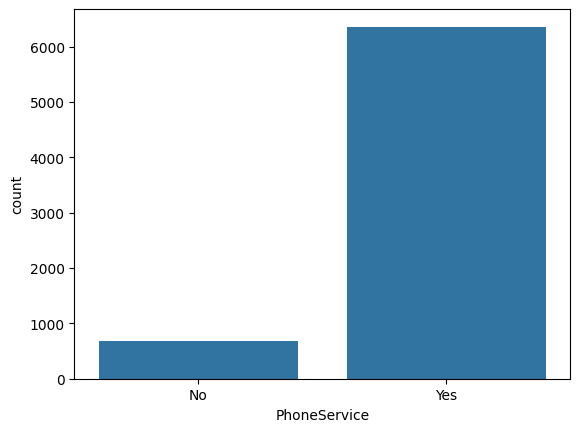

                  MultipleLines  Ratio
MultipleLines                         
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
Distribution of MultipleLines


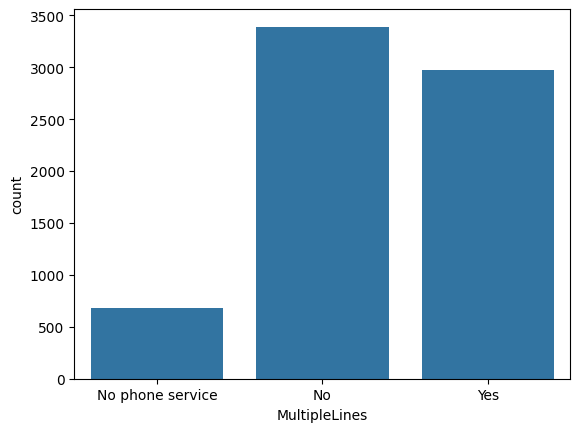

                 InternetService  Ratio
InternetService                        
Fiber optic                 3096 43.959
DSL                         2421 34.375
No                          1526 21.667
Distribution of InternetService


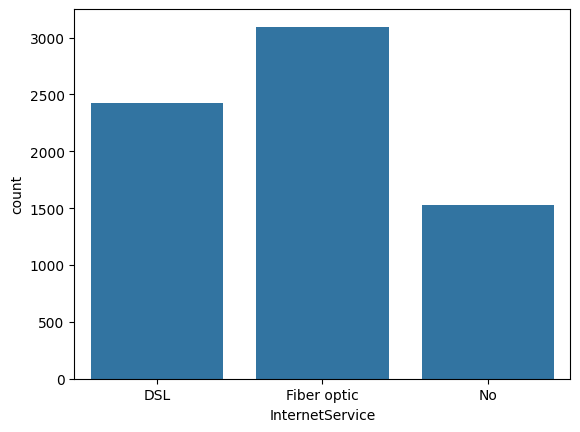

                     OnlineSecurity  Ratio
OnlineSecurity                            
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667
Distribution of OnlineSecurity


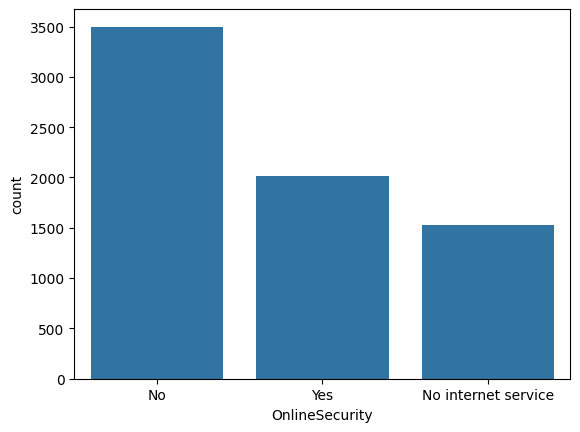

                     OnlineBackup  Ratio
OnlineBackup                            
No                           3088 43.845
Yes                          2429 34.488
No internet service          1526 21.667
Distribution of OnlineBackup


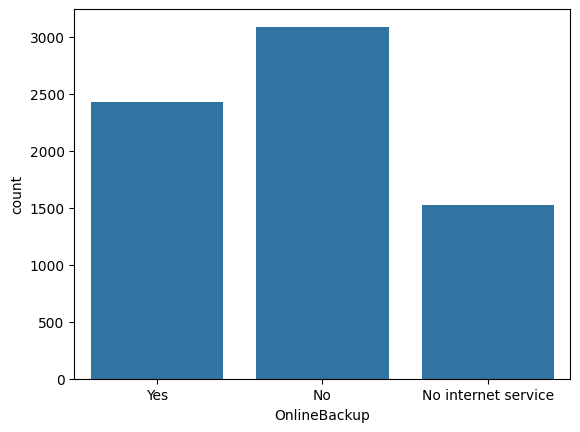

                     DeviceProtection  Ratio
DeviceProtection                            
No                               3095 43.944
Yes                              2422 34.389
No internet service              1526 21.667
Distribution of DeviceProtection


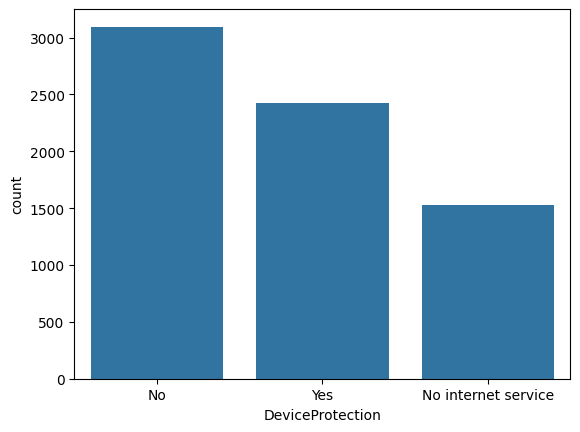

                     TechSupport  Ratio
TechSupport                            
No                          3473 49.311
Yes                         2044 29.022
No internet service         1526 21.667
Distribution of TechSupport


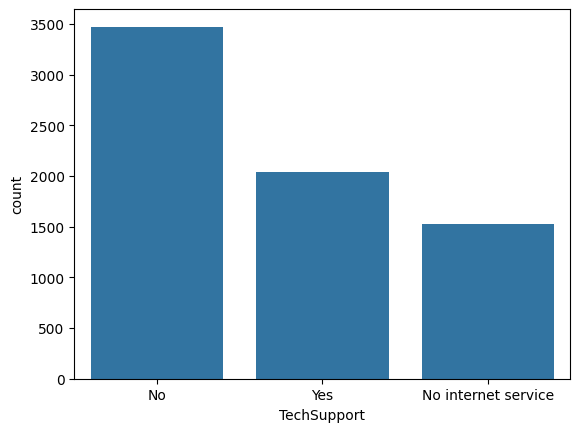

                     StreamingTV  Ratio
StreamingTV                            
No                          2810 39.898
Yes                         2707 38.435
No internet service         1526 21.667
Distribution of StreamingTV


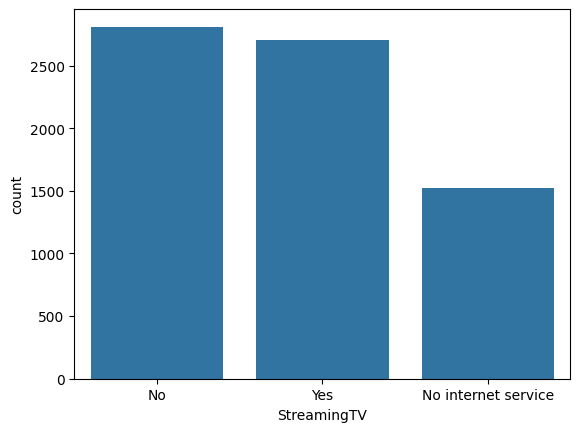

                     StreamingMovies  Ratio
StreamingMovies                            
No                              2785 39.543
Yes                             2732 38.790
No internet service             1526 21.667
Distribution of StreamingMovies


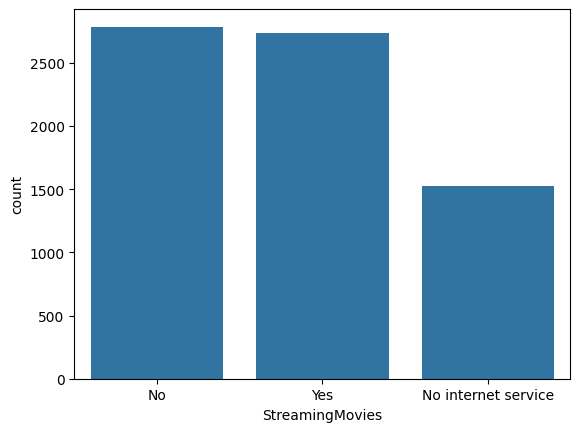

                Contract  Ratio
Contract                       
Month-to-month      3875 55.019
Two year            1695 24.066
One year            1473 20.914
Distribution of Contract


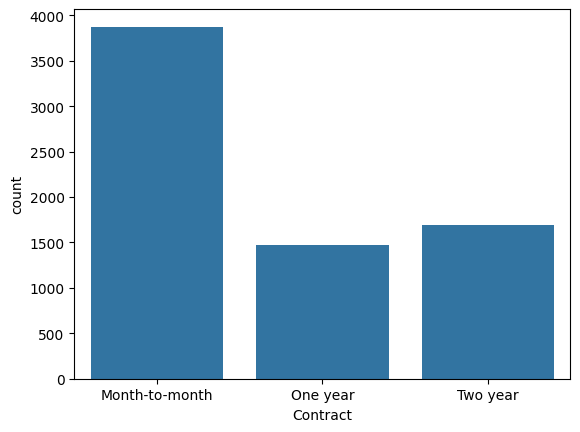

                  PaperlessBilling  Ratio
PaperlessBilling                         
Yes                           4171 59.222
No                            2872 40.778
Distribution of PaperlessBilling


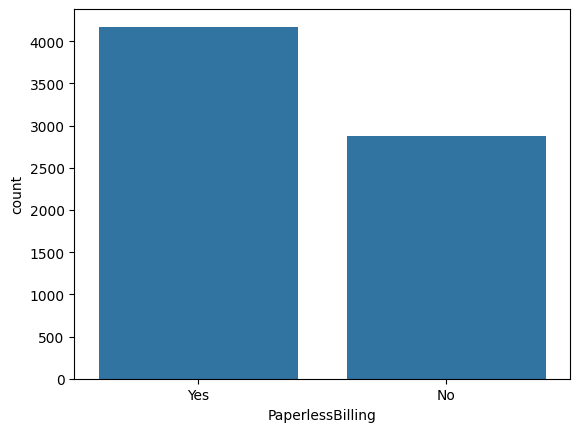

                           PaymentMethod  Ratio
PaymentMethod                                  
Electronic check                    2365 33.579
Mailed check                        1612 22.888
Bank transfer (automatic)           1544 21.922
Credit card (automatic)             1522 21.610
Distribution of PaymentMethod


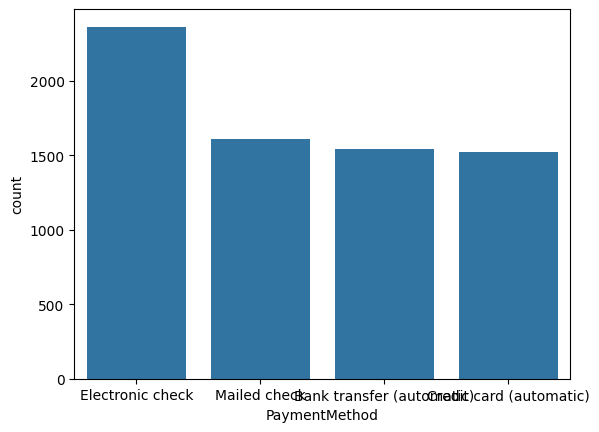

       Churn  Ratio
Churn              
0       5174 73.463
1       1869 26.537
Distribution of Churn


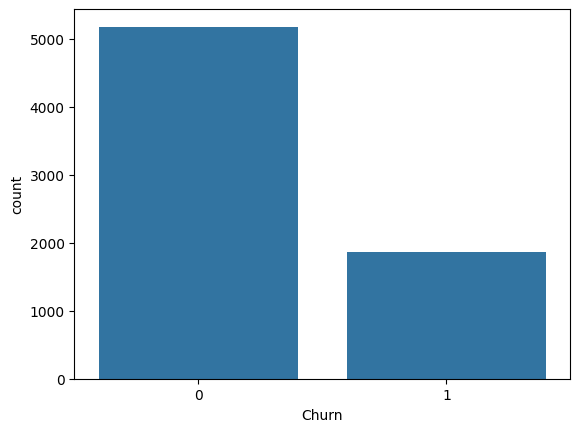

In [14]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print(f"Distribution of {col_name}")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
for col in cat_cols:
    cat_summary(df, col, plot=True)

**Numarical Veriables Distribution Analysis**

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


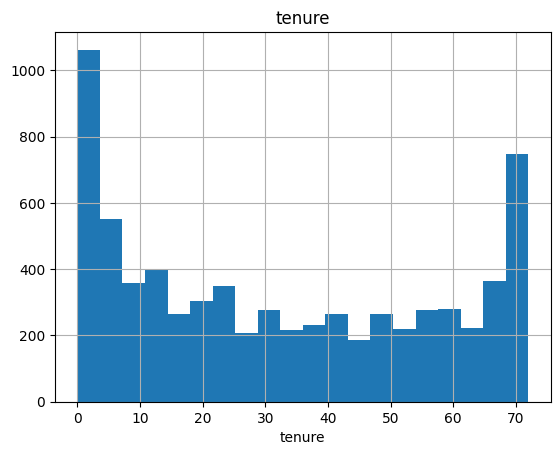

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


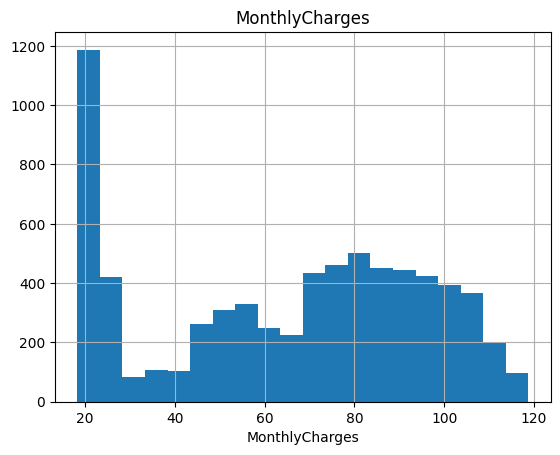

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


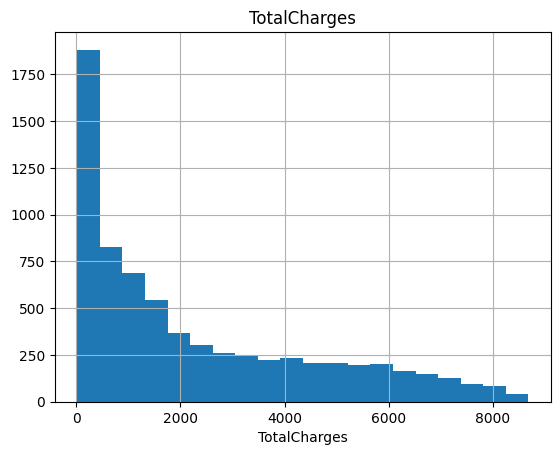

In [15]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
for col in num_cols:
    num_summary(df, col, plot=True)

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


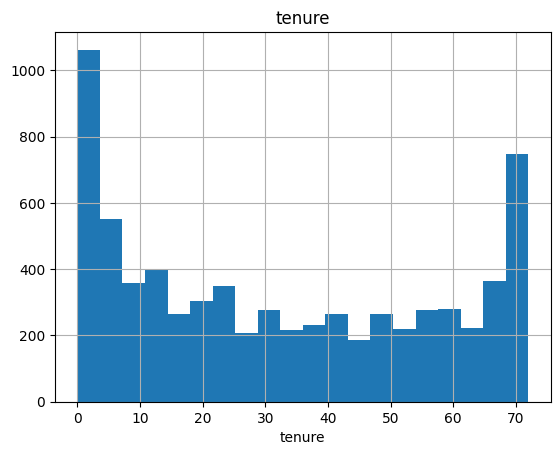

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


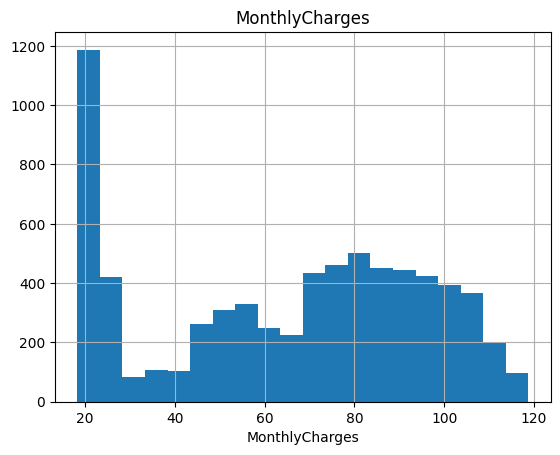

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


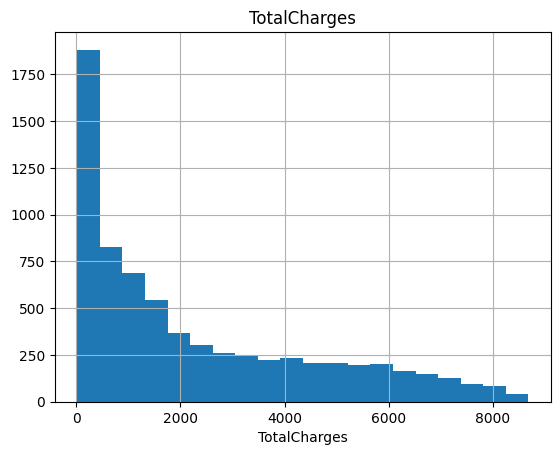

In [16]:
for col in num_cols:
    num_summary(df, col, plot=True)

**Analysis of Numeric Variables by Target**
Analyzes the relationship between a numerical variable and a categorical target variable by calculating the mean of numerical columns for each category in the target column.

In [17]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}))
    print("---------------------------------------------------------------")
for col in num_cols:
    target_summary_with_num(df, "Churn", col)

       tenure
Churn        
0      37.570
1      17.979
---------------------------------------------------------------
       MonthlyCharges
Churn                
0              61.265
1              74.441
---------------------------------------------------------------
       TotalCharges
Churn              
0          2555.344
1          1531.796
---------------------------------------------------------------


**Analyzes the relationship between a categorical feature and a target variable by calculating:**

* Mean of the target variable for each category (useful for classification problems).
* Count of each category in the dataset.
* Percentage (ratio) of each category in the dataset.

In [18]:
print("Relationship between a Categorical Veriables and a Target Variable")
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}))
    print("---------------------------------------------------------------")
for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

Relationship between a Categorical Veriables and a Target Variable
gender
        TARGET_MEAN  Count  Ratio
gender                           
Female        0.269   3488 49.524
Male          0.262   3555 50.476
---------------------------------------------------------------
SeniorCitizen
               TARGET_MEAN  Count  Ratio
SeniorCitizen                           
0                    0.236   5901 83.785
1                    0.417   1142 16.215
---------------------------------------------------------------
Partner
         TARGET_MEAN  Count  Ratio
Partner                           
No             0.330   3641 51.697
Yes            0.197   3402 48.303
---------------------------------------------------------------
Dependents
            TARGET_MEAN  Count  Ratio
Dependents                           
No                0.313   4933 70.041
Yes               0.155   2110 29.959
---------------------------------------------------------------
PhoneService
              TARGET_MEAN  Count

**Applies a logarithmic Transformation**
* Helps reduce skewness in data and make it more normally distributed
*  logarithmic transformation to the "Churn" column and plots its histogram to visualize the distribution.

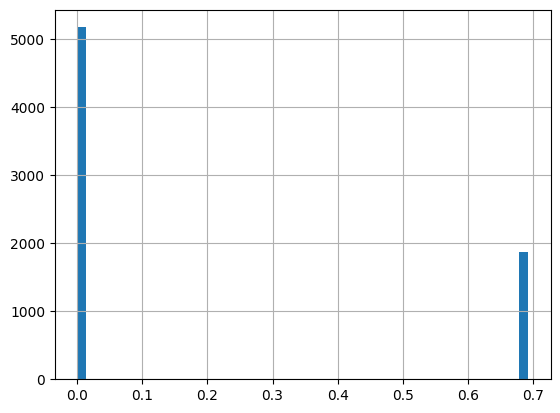

In [19]:
np.log1p(df["Churn"]).hist(bins=50)
plt.show(block=True)

**Dataset Correlation Analysis**

In [20]:
#Correlation of the Numarical Veriables
corr = df[num_cols].corr()
corr

,tenure,MonthlyCharges,TotalCharges
tenure,1.000,0.248,0.826
MonthlyCharges,0.248,1.000,0.651
TotalCharges,0.826,0.651,1.000


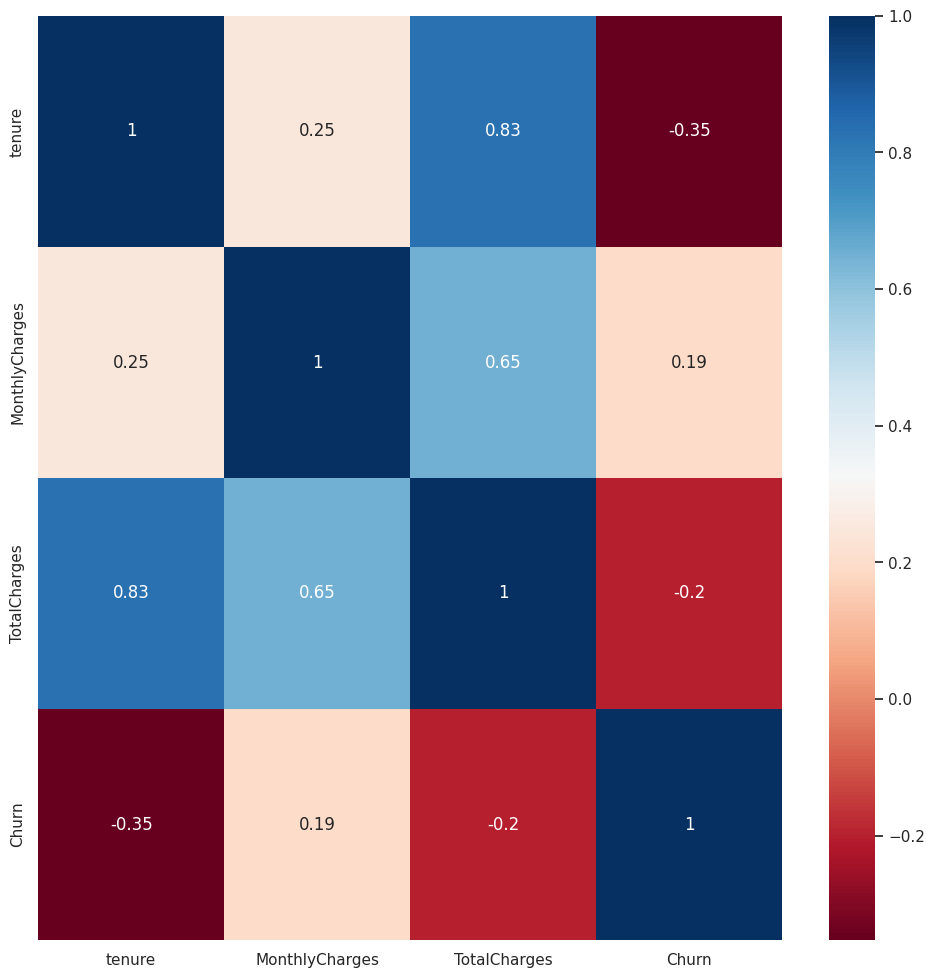

Highly Correlated Columns: ['TotalCharges']


In [21]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    # Select only numeric columns to avoid string conversion errors
    num_df = dataframe.select_dtypes(include=['number'])  # Keeps only numerical columns

    corr = num_df.corr()  # Compute correlation only for numerical data
    cor_matrix = corr.abs()  # Get absolute correlation values

    # Extract upper triangle of correlation matrix to avoid duplicate values
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

    # Identify columns with high correlation
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    # Optional: Plot heatmap
    if plot:
        sns.set(rc={"figure.figsize": (12, 12)})
        corr_values = corr.round(2)
        sns.heatmap(corr, cmap="RdBu", annot=corr_values)
        plt.show()
    return drop_list
# Run function
drop_columns = high_correlated_cols(df, plot=True)
print("Highly Correlated Columns:", drop_columns)


**Data Cleaning**

This Section will disscuss


* Missing Values Detection
* Outlier Detection



In [22]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


 **This function** identifies missing values in a given DataFrame and provides
    a summary of missing counts and percentages. It also offers an optional
    visualization of missing values.
    
    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to analyze.
    - na_name (bool): If True, returns a list of column names containing missing values.
    - plot (bool): If True, plots a bar chart of missing values.
    Returns:
    - If na_name=True, returns a list of column names with missing values.

In [23]:

def missing_values_table(dataframe, na_name=False, plot=False):
    # Identify columns with missing values
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    # Count of missing values per column, sorted in descending order
    Missing_value = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    # Percentage of missing values per column
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    # Create a summary DataFrame for missing values
    missing_df = pd.concat([Missing_value, np.round(ratio, 2)], axis=1, keys=['Missing_value', 'ratio'])

    # Print the missing values summary
    print(missing_df, end="\n")

    # If plot=True, generate a bar chart of missing values
    if plot:
        plt.figure(figsize=(10, 8))  # Set figure size
        bars = plt.bar(missing_df.index, missing_df['ratio'], color='red')  # Create bars

        # Add labels and title
        plt.xlabel('Variables')
        plt.ylabel('Missing Values Percentage')
        plt.title('Missing Values by Variables')

        # Annotate bars with missing percentage values
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='bottom')

        plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
        plt.tight_layout()  # Adjust layout for better fit
        plt.show(block=True)  # Display the plot

    # If na_name=True, return the list of columns with missing values
    if na_name:
        return na_columns


              Missing_value  ratio
TotalCharges             11  0.160


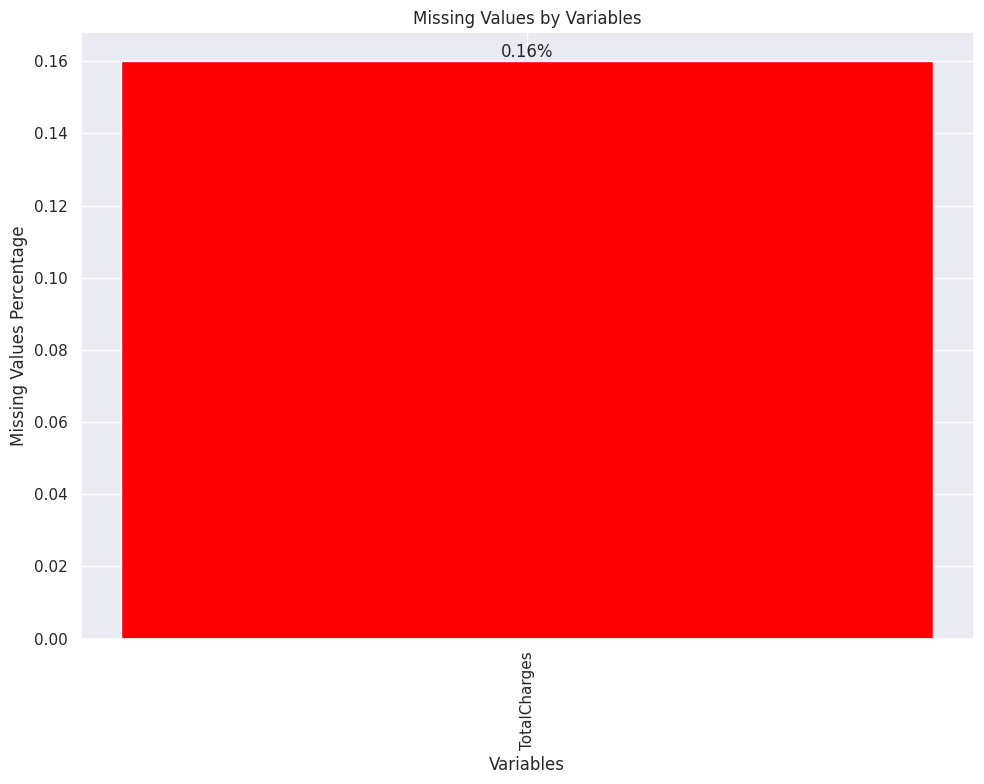

In [24]:
na_columns = missing_values_table(df, na_name=True, plot=True)

In [25]:
def missing_vs_target(dataframe, target, na_columns, plot=False):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + ' NA'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains(" NA")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")
        if plot:
            # Plotting the target mean by NA flag
            plt.figure(figsize=(6, 4))
            temp_df.groupby(col)[target].mean().plot(kind='bar', color='red')
            plt.xlabel(col)
            plt.ylabel('Target Mean')
            plt.title(f'Target Mean by {col}')
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show(block=True)
#            print("---------------------------------------------------")

                 TARGET_MEAN  Count
TotalCharges NA                    
0                      0.266   7032
1                      0.000     11




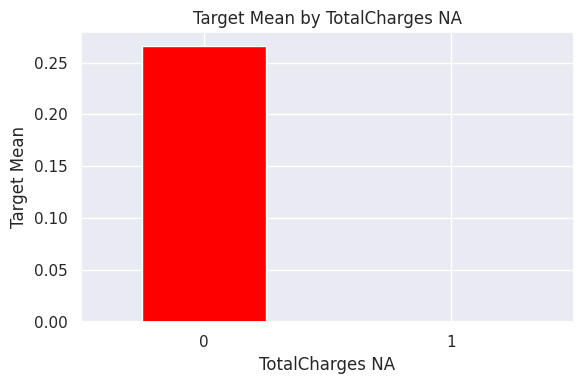

In [26]:
missing_vs_target(df, "Churn", na_columns, plot=True)

In [27]:
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


**Outlier Detection and Analysis**

In [28]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [29]:
def check_outlier(dataframe, col_name, plot=False):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    outliers = dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)]
    if outliers.any(axis=None):
        if plot:
            plt.figure(figsize=(8, 6))
            sns.boxplot(x=dataframe[col_name])
            plt.title(f'Outliers in {col_name}')
            plt.show()
        return True
    else:
        return False

In [30]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [31]:
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

tenure False
MonthlyCharges False
TotalCharges False


**Deuplicate Dataframe**
To save orignal dataframe and prform some modifaction in dataframe.

In [32]:
dff = df.copy()
cat_cols = [col for col in cat_cols if col not in ["Churn"]]
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

**One-Hot Encoding**

One-hot encoding is a technique used to convert categorical variables (e.g., "Gender", "Country") into a format that can be provided to machine learning algorithms, typically as binary columns (0 or 1)

In [33]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [34]:
dff = one_hot_encoder(dff, cat_cols)
dff.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,29.850,29.850,0,True,False,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
1,5575-GNVDE,34,56.950,1889.500,0,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True
2,3668-QPYBK,2,53.850,108.150,1,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
3,7795-CFOCW,45,42.300,1840.750,0,False,True,True,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False
4,9237-HQITU,2,70.700,151.650,1,True,False,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False


**Standardization**

Applies Robust Scaling to the numerical columns

making the data more robust to outliers. This transformation is useful in situations where the dataset has extreme values or outliers that could skew the scaling if other methods were used

In [35]:
scaler = RobustScaler()
dff[num_cols] = scaler.fit_transform(dff[num_cols])
dff.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,-0.609,-0.745,-0.404,0,True,False,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
1,5575-GNVDE,0.109,-0.247,0.145,0,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True
2,3668-QPYBK,-0.587,-0.304,-0.381,1,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
3,7795-CFOCW,0.348,-0.516,0.131,0,False,True,True,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False
4,9237-HQITU,-0.587,0.006,-0.368,1,True,False,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False


**Contructing Dependent Variable**

Process of separating the target variable

In [36]:
y = dff["Churn"]
X = dff.drop(["Churn","customerID"], axis=1)

**Modeling**

Defining a list of different machine learning models that will likely be used for classification tasks

In [37]:
models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(random_state=12345)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))]

In [38]:
base_models_metrics = []

**Performing cross-validation** on a list of machine learning models (models) and evaluating them based on multiple performance metrics

In [39]:
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])

    accuracy = round(cv_results['test_accuracy'].mean(), 4)
    auc = round(cv_results['test_roc_auc'].mean(), 4)
    recall = round(cv_results['test_recall'].mean(), 4)
    precision = round(cv_results['test_precision'].mean(), 4)
    f1 = round(cv_results['test_f1'].mean(), 4)

    base_models_metrics.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Recall": recall,
        "Precision": precision,
        "F1": f1
    })

    print(f"---------------------- {name} --------------------")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1: {f1}")

---------------------- LR --------------------
Accuracy: 0.8041
AUC: 0.8452
Recall: 0.5516
Precision: 0.6554
F1: 0.5989
---------------------- KNN --------------------
Accuracy: 0.7673
AUC: 0.7801
Recall: 0.5313
Precision: 0.5655
F1: 0.5478
---------------------- CART --------------------
Accuracy: 0.7294
AUC: 0.6547
Recall: 0.4917
Precision: 0.4899
F1: 0.4906
---------------------- RF --------------------
Accuracy: 0.7889
AUC: 0.8172
Recall: 0.4842
Precision: 0.6346
F1: 0.5492
---------------------- XGB --------------------
Accuracy: 0.7832
AUC: 0.8193
Recall: 0.5168
Precision: 0.609
F1: 0.5587
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

**Model Comparison** of Metrics for Different Models Before Feature Engineering

Visualizes the results using a bar plot to compare the performance of different models

In [40]:
# Containing the updated metric results
metrics = {
    "Model": ["LR", "KNN", "CART", "RF", "XGB", "LightGBM", "CatBoost"],
    "Accuracy": [base_models_metrics[0]['Accuracy'], base_models_metrics[1]['Accuracy'],
                 base_models_metrics[2]['Accuracy'], base_models_metrics[3]['Accuracy'],
                 base_models_metrics[4]['Accuracy'], base_models_metrics[5]['Accuracy'],
                 base_models_metrics[6]['Accuracy']],
    "AUC": [base_models_metrics[0]['AUC'], base_models_metrics[1]['AUC'],
            base_models_metrics[2]['AUC'], base_models_metrics[3]['AUC'],
            base_models_metrics[4]['AUC'], base_models_metrics[5]['AUC'],
            base_models_metrics[6]['AUC']],
    "Recall": [base_models_metrics[0]['Recall'], base_models_metrics[1]['Recall'],
               base_models_metrics[2]['Recall'], base_models_metrics[3]['Recall'],
               base_models_metrics[4]['Recall'], base_models_metrics[5]['Recall'],
               base_models_metrics[6]['Recall']],
    "Precision": [base_models_metrics[0]['Precision'], base_models_metrics[1]['Precision'],
                  base_models_metrics[2]['Precision'], base_models_metrics[3]['Precision'],
                  base_models_metrics[4]['Precision'], base_models_metrics[5]['Precision'],
                  base_models_metrics[6]['Precision']],
    "F1": [base_models_metrics[0]['F1'], base_models_metrics[1]['F1'],
           base_models_metrics[2]['F1'], base_models_metrics[3]['F1'],
           base_models_metrics[4]['F1'], base_models_metrics[5]['F1'],
           base_models_metrics[6]['F1']]
}
# Creating a DataFrame from the updated metrics
results_df = pd.DataFrame(metrics)
# Sorting the DataFrame by accuracy in descending order
results_df = results_df.sort_values(by="Accuracy", ascending=False)
# Creating the figure for the graph
fig = go.Figure()
# Colors for the metrics
colors = ["purple", "green", "blue", "orange", "red"]
# Adding traces for each metric in the specified order
for metric, color in zip(["Accuracy", "AUC", "Recall", "Precision", "F1"], colors):
    fig.add_trace(go.Bar(
        x=results_df["Model"],
        y=results_df[metric],
        marker_color=color,
        name=metric,
        text=results_df[metric],
        textposition='auto'
    ))
# Setting axis labels and title
fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Metric Score",
    title="Comparison of Metrics for Different Models Before Feature Engineering"
)
# Displaying the graph
fig.show(block=True)

**Feature Importance** With Respect to Model Classifaction

In [41]:
models = [RandomForestClassifier(),
              XGBClassifier(),
              LGBMClassifier(),
              CatBoostClassifier(verbose=False, random_state=12345)
              ]

In [42]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig(f'importances_{model.__class__.__name__}.png')

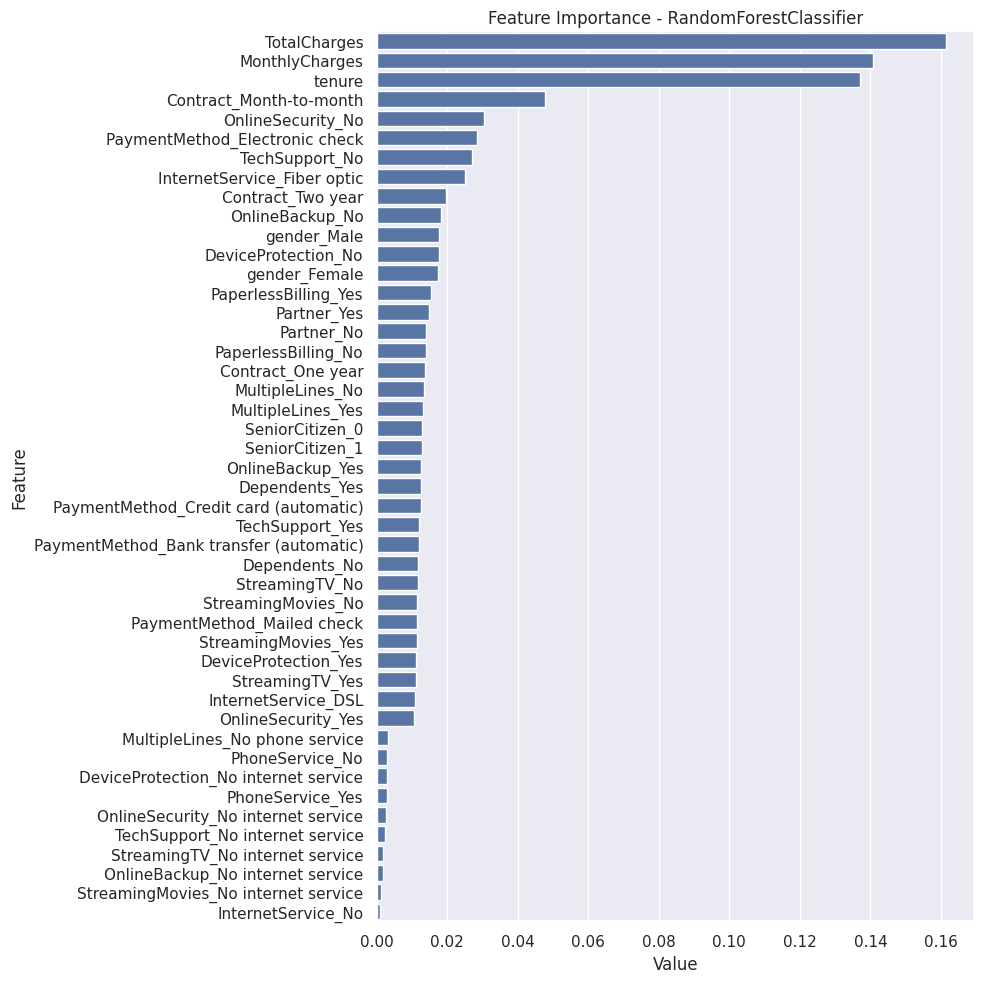

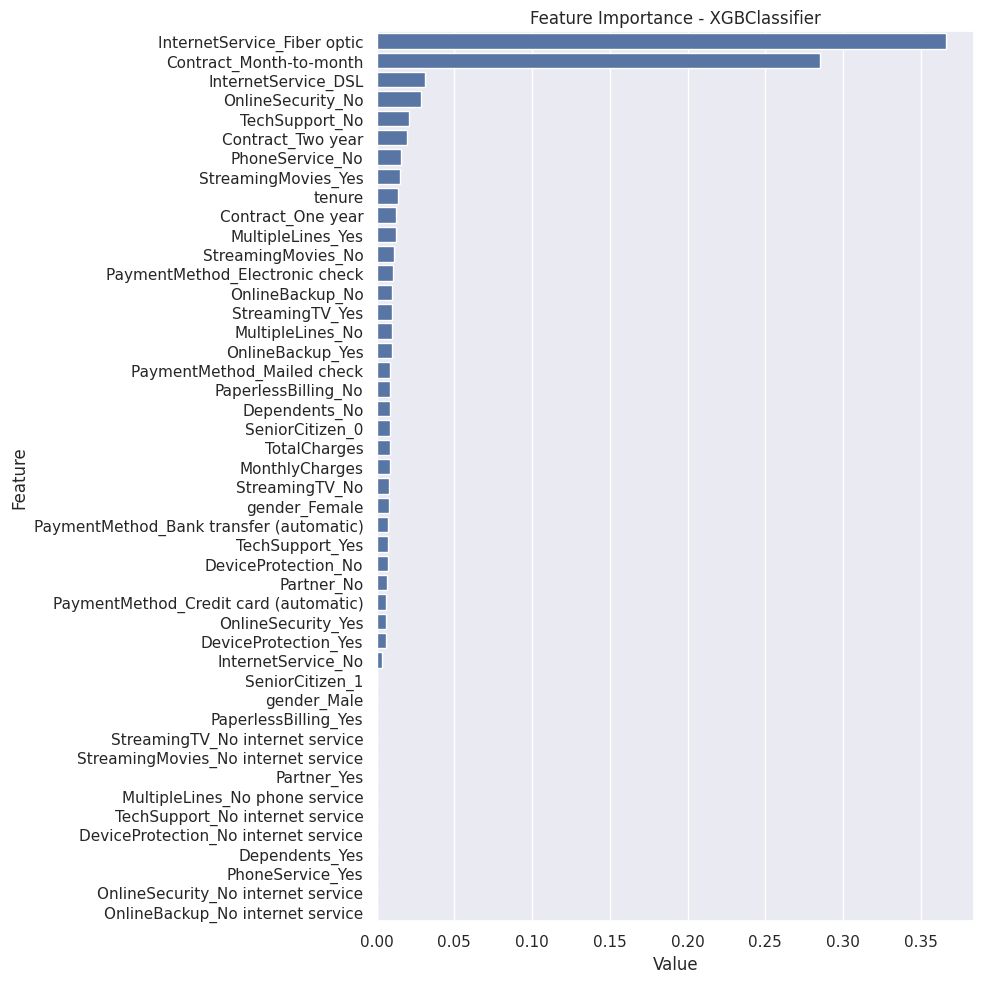

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1869, number of negative: 5174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 7043, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265370 -> initscore=-1.018243
[LightGBM] [Info] Start training from score -1.018243


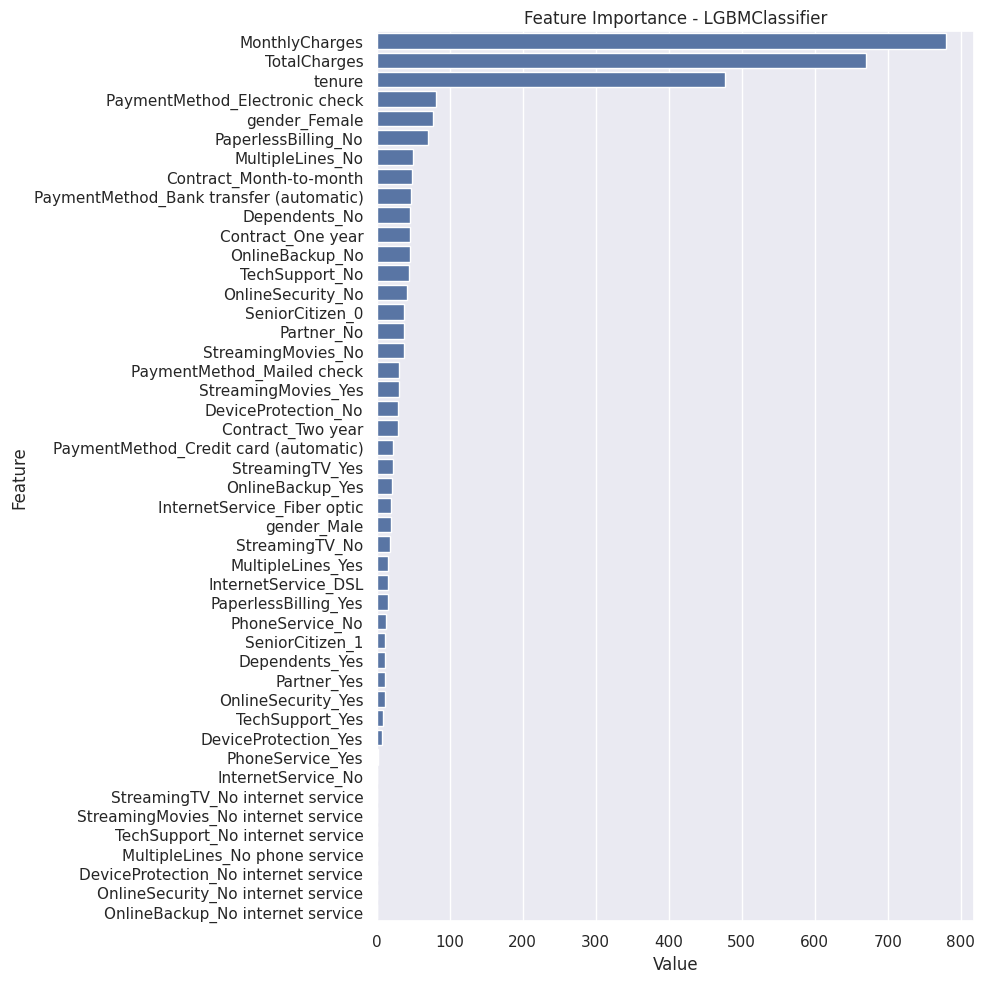

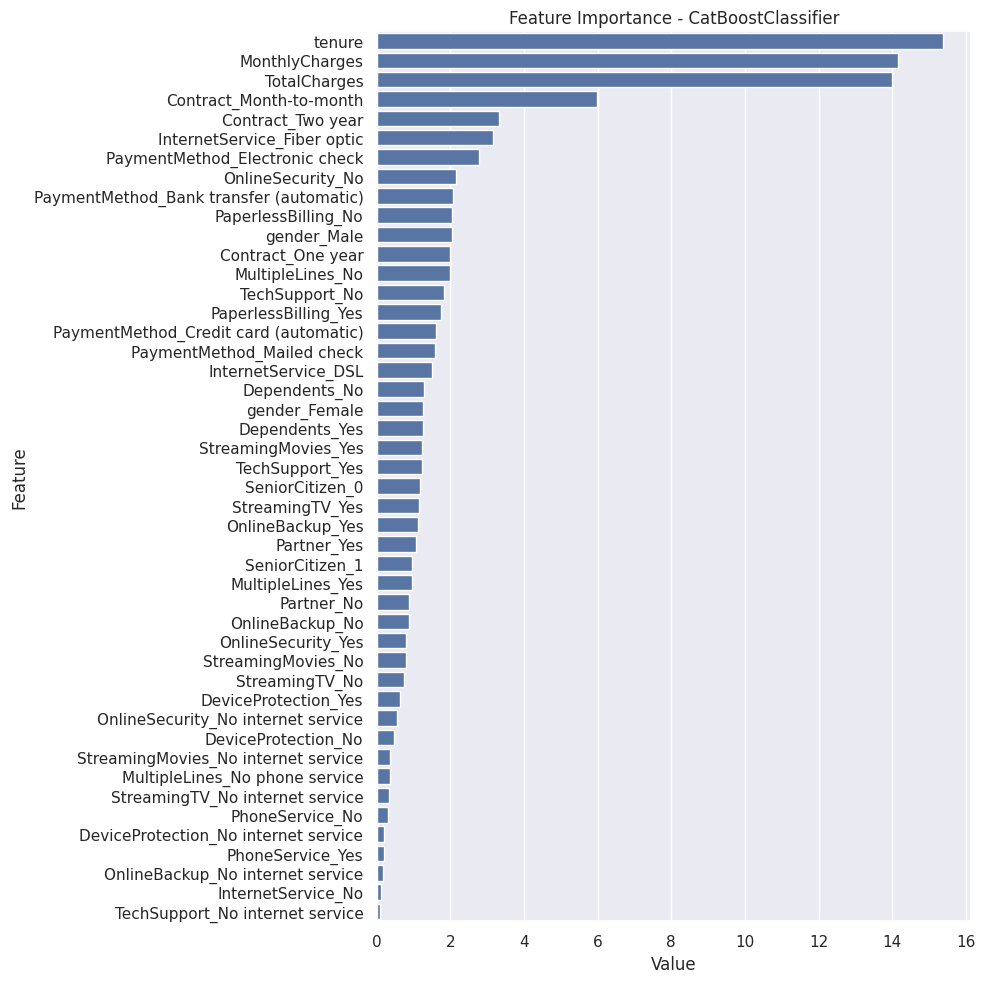

In [43]:
for model in models:
    model.fit(X, y)
    plot_importance(model, X)

**Feature Extraction**

Creates new features in the dataframe df based on existing data. These new features are derived from the current variables.

NEW_TENURE_YEAR

NEW_Engaged

NEW_noProt

NEW_Young_Not_Engaged

NEW_TotalServices

NEW_FLAG_ANY_STREAMING

NEW_FLAG_AutoPayment

NEW_AVG_Charges

NEW_Increase

NEW_AVG_Service_Fee

In [44]:
# Create an annual categorical variable from the variable Tenure
df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)
# People who do not receive any support, backup or protection
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)
# Young customers with a monthly contract
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)
# Total number of services received by the person
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)
# People who receive any streaming service
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)
# Does the person make automatic payments?
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)
# average monthly payment
df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)
# Increase in current price compared to average price
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]
# Fee per service
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,0,0,14.925,0.500,14.925
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3,0,0,53.986,0.948,14.238
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3,0,0,36.050,0.669,13.463
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,1,40.016,0.946,10.575
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,50.550,0.715,35.350


In [45]:
df.shape

(7043, 31)

**ENCODING**

Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
Note Categorical variables include categorical variables with numeric appearance.

In [46]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [47]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)
print("-----------------------------------------")
cat_cols

num_cols

cat_but_car

Observations: 7043
Variables: 31
cat_cols: 24
num_cols: 6
cat_but_car: 1
num_but_cat: 7
-----------------------------------------


['customerID']

**Label Encoding**

performing Label Encoding on binary categorical columns in the dataframe. Label Encoding is a technique used to convert categorical data into numerical form

In [48]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols
for col in binary_cols:
    df = label_encoder(df, col)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,0,0,14.925,0.500,14.925
1,5575-GNVDE,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3,0,0,53.986,0.948,14.238
2,3668-QPYBK,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3,0,0,36.050,0.669,13.463
3,7795-CFOCW,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,1,40.016,0.946,10.575
4,9237-HQITU,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,50.550,0.715,35.350


**One-Hot Encoding**

In [49]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment']

In [50]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
df = one_hot_encoder(df, cat_cols)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_0-1 Year,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,NEW_Engaged_0,NEW_Engaged_1,NEW_noProt_0,NEW_noProt_1,NEW_Young_Not_Engaged_0,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_0,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_0,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,0,1,0,1,0,1,29.850,29.850,0,1,14.925,0.500,14.925,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False
1,5575-GNVDE,1,0,0,0,34,1,0,56.950,1889.500,0,3,53.986,0.948,14.238,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,True,False,True,False,True,False
2,3668-QPYBK,1,0,0,0,2,1,1,53.850,108.150,1,3,36.050,0.669,13.463,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False
3,7795-CFOCW,1,0,0,0,45,0,0,42.300,1840.750,0,3,40.016,0.946,10.575,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,True,False,True,False,False,True
4,9237-HQITU,0,0,0,0,2,1,1,70.700,151.650,1,1,50.550,0.715,35.350,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False


**Standardization Process**



In [51]:
scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_0-1 Year,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,NEW_Engaged_0,NEW_Engaged_1,NEW_noProt_0,NEW_noProt_1,NEW_Young_Not_Engaged_0,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_0,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_0,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,0,1,0,-0.609,0,1,-0.745,-0.404,0,1,-0.788,-4.604,-0.061,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False
1,5575-GNVDE,1,0,0,0,0.109,1,0,-0.247,0.145,0,3,-0.122,-0.110,-0.136,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,True,False,True,False,True,False
2,3668-QPYBK,1,0,0,0,-0.587,1,1,-0.304,-0.381,1,3,-0.428,-2.904,-0.221,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False
3,7795-CFOCW,1,0,0,0,0.348,0,0,-0.516,0.131,0,3,-0.360,-0.129,-0.537,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,True,False,True,False,False,True
4,9237-HQITU,0,0,0,0,-0.587,1,1,0.006,-0.368,1,1,-0.181,-2.447,2.172,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False
5,9305-CDSKC,0,0,0,0,-0.457,1,1,0.539,-0.170,1,4,0.512,-0.442,0.486,False,False,True,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,True,False,True,True,False
6,1452-KIOVK,1,0,0,1,-0.152,1,1,0.345,0.163,0,3,0.402,-0.077,0.742,False,False,True,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False,True,False,True
7,6713-OKOMC,0,0,0,0,-0.413,0,0,-0.747,-0.324,0,1,-0.575,-0.365,-0.067,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False
8,7892-POOKP,0,0,1,0,-0.022,1,1,0

***Constructing Model After Feature Engeenring ***

In [52]:
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)
models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(random_state=12345)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))]
last_models_metrics = []

In [53]:
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])

    accuracy = round(cv_results['test_accuracy'].mean(), 4)
    auc = round(cv_results['test_roc_auc'].mean(), 4)
    recall = round(cv_results['test_recall'].mean(), 4)
    precision = round(cv_results['test_precision'].mean(), 4)
    f1 = round(cv_results['test_f1'].mean(), 4)

    last_models_metrics.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Recall": recall,
        "Precision": precision,
        "F1": f1
    })

    print(f"--------------------------- {name}-----------------------------")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1: {f1}")

--------------------------- LR-----------------------------
Accuracy: 0.8052
AUC: 0.8499
Recall: 0.5367
Precision: 0.6651
F1: 0.5939
--------------------------- KNN-----------------------------
Accuracy: 0.7711
AUC: 0.7834
Recall: 0.5254
Precision: 0.5756
F1: 0.5492
--------------------------- CART-----------------------------
Accuracy: 0.7311
AUC: 0.6583
Recall: 0.4997
Precision: 0.4936
F1: 0.4965
--------------------------- RF-----------------------------
Accuracy: 0.7893
AUC: 0.823
Recall: 0.4858
Precision: 0.6357
F1: 0.5506
--------------------------- XGB-----------------------------
Accuracy: 0.7805
AUC: 0.819
Recall: 0.4912
Precision: 0.6078
F1: 0.5431
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

**Metrics Comparison After after Feature Engineering**

In [55]:
metrics = {
    "Model": ["LR", "KNN", "CART", "RF", "XGB", "LightGBM", "CatBoost"],
    "Accuracy": [last_models_metrics[0]['Accuracy'], last_models_metrics[1]['Accuracy'],
                 last_models_metrics[2]['Accuracy'], last_models_metrics[3]['Accuracy'],
                 last_models_metrics[4]['Accuracy'], last_models_metrics[5]['Accuracy'],
                 last_models_metrics[6]['Accuracy']],
    "AUC": [last_models_metrics[0]['AUC'], last_models_metrics[1]['AUC'],
            last_models_metrics[2]['AUC'], last_models_metrics[3]['AUC'],
            last_models_metrics[4]['AUC'], last_models_metrics[5]['AUC'],
            last_models_metrics[6]['AUC']],
    "Recall": [last_models_metrics[0]['Recall'], last_models_metrics[1]['Recall'],
               last_models_metrics[2]['Recall'], last_models_metrics[3]['Recall'],
               last_models_metrics[4]['Recall'], last_models_metrics[5]['Recall'],
               last_models_metrics[6]['Recall']],
    "Precision": [last_models_metrics[0]['Precision'], last_models_metrics[1]['Precision'],
                  last_models_metrics[2]['Precision'], last_models_metrics[3]['Precision'],
                  last_models_metrics[4]['Precision'], last_models_metrics[5]['Precision'],
                  last_models_metrics[6]['Precision']],
    "F1": [last_models_metrics[0]['F1'], last_models_metrics[1]['F1'],
           last_models_metrics[2]['F1'], last_models_metrics[3]['F1'],
           last_models_metrics[4]['F1'], last_models_metrics[5]['F1'],
           last_models_metrics[6]['F1']]
}

# Creating a DataFrame from the updated metrics dictionary
results_df = pd.DataFrame(metrics)

# Sorting the DataFrame by accuracy in descending order
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Creating the figure for the graph
fig = go.Figure()

# Colors for the metrics
colors = ["purple", "green", "blue", "orange", "red"]

# Adding traces for each metric in the specified order
for metric, color in zip(["Accuracy", "AUC", "Recall", "Precision", "F1"], colors):
    fig.add_trace(go.Bar(
        x=results_df["Model"],
        y=results_df[metric],
        marker_color=color,
        name=metric,
        text=results_df[metric],
        textposition='auto'
    ))

# Setting axis labels and title
fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Metric Score",
    title="Models Comparison After Feature Engineering"
)

# Displaying the graph
fig.show(block=True)

**Imprtant Features**

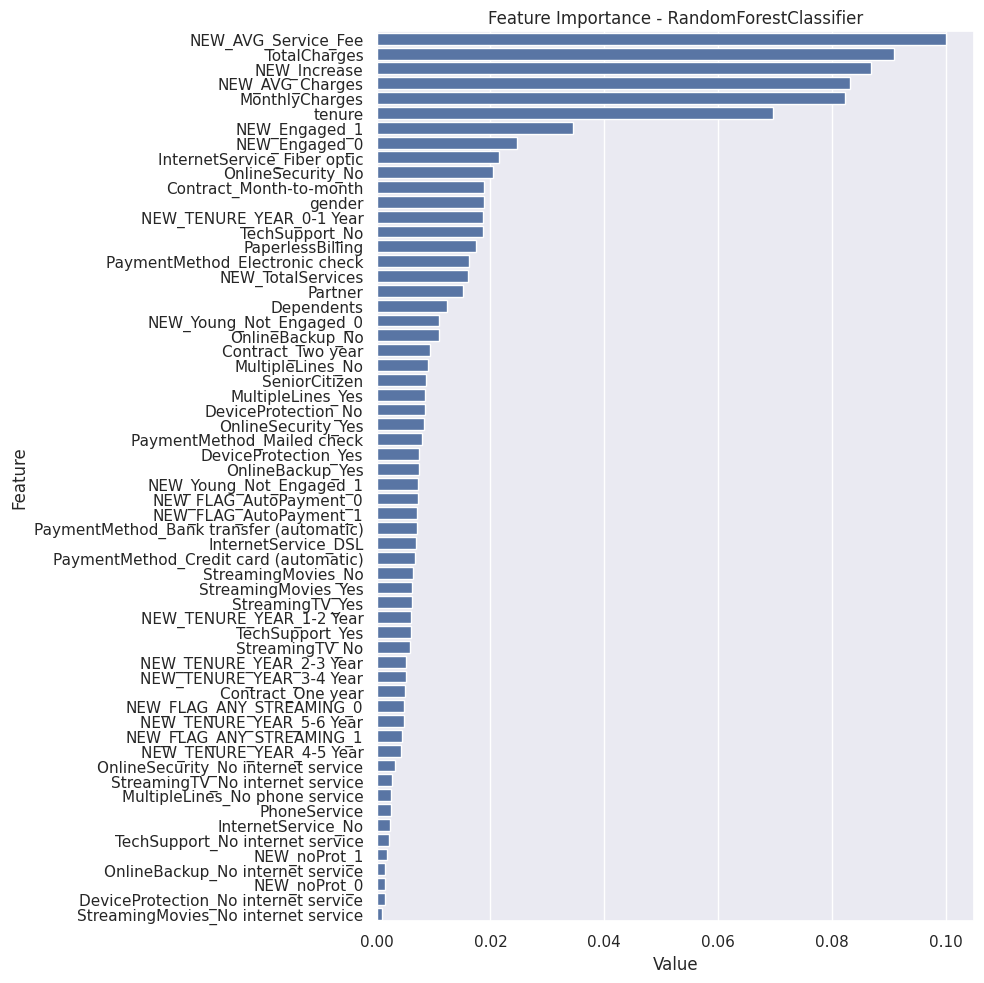

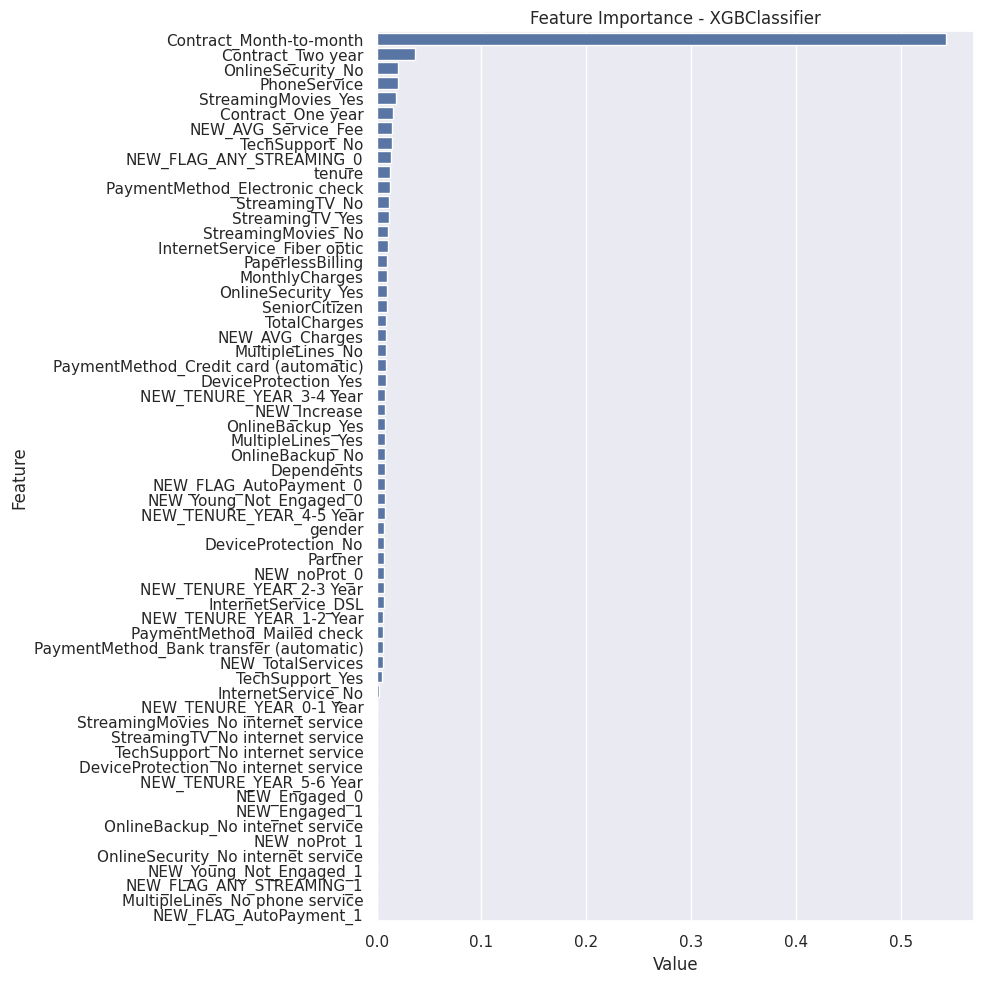

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1869, number of negative: 5174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1462
[LightGBM] [Info] Number of data points in the train set: 7043, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265370 -> initscore=-1.018243
[LightGBM] [Info] Start training from score -1.018243


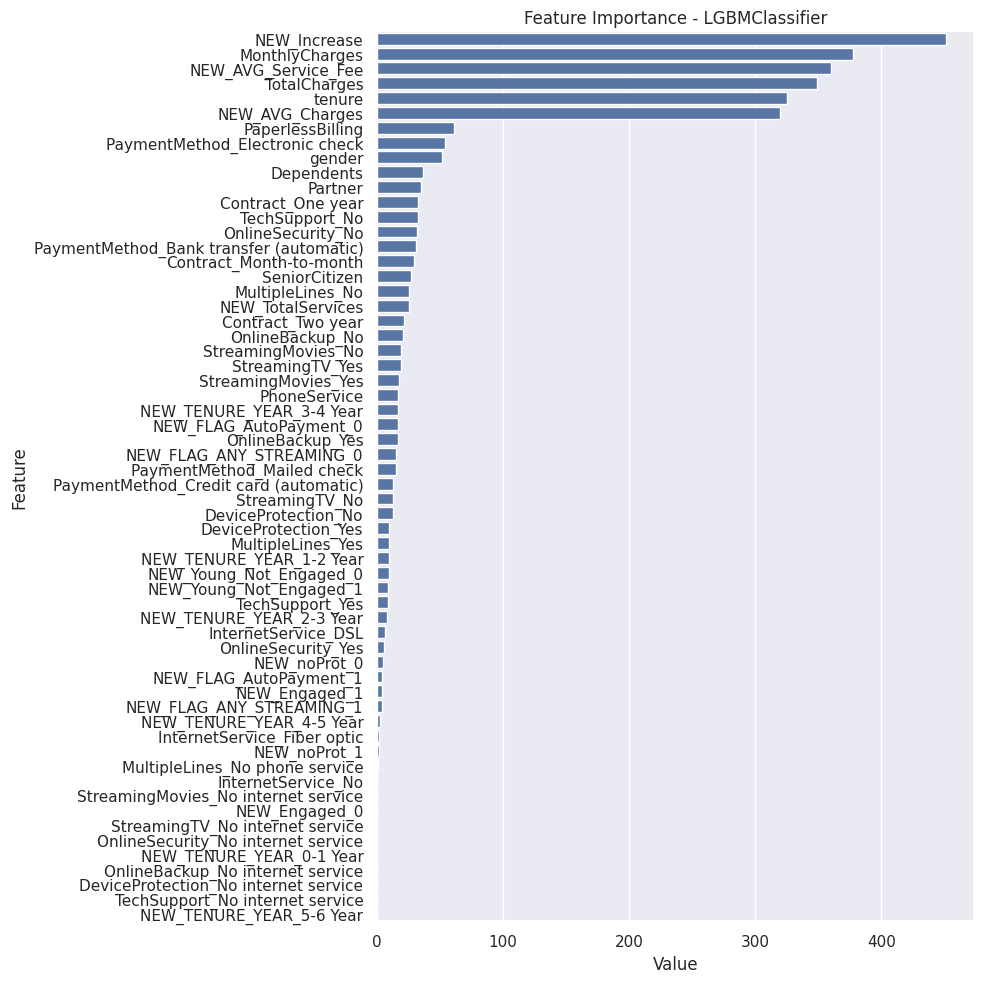

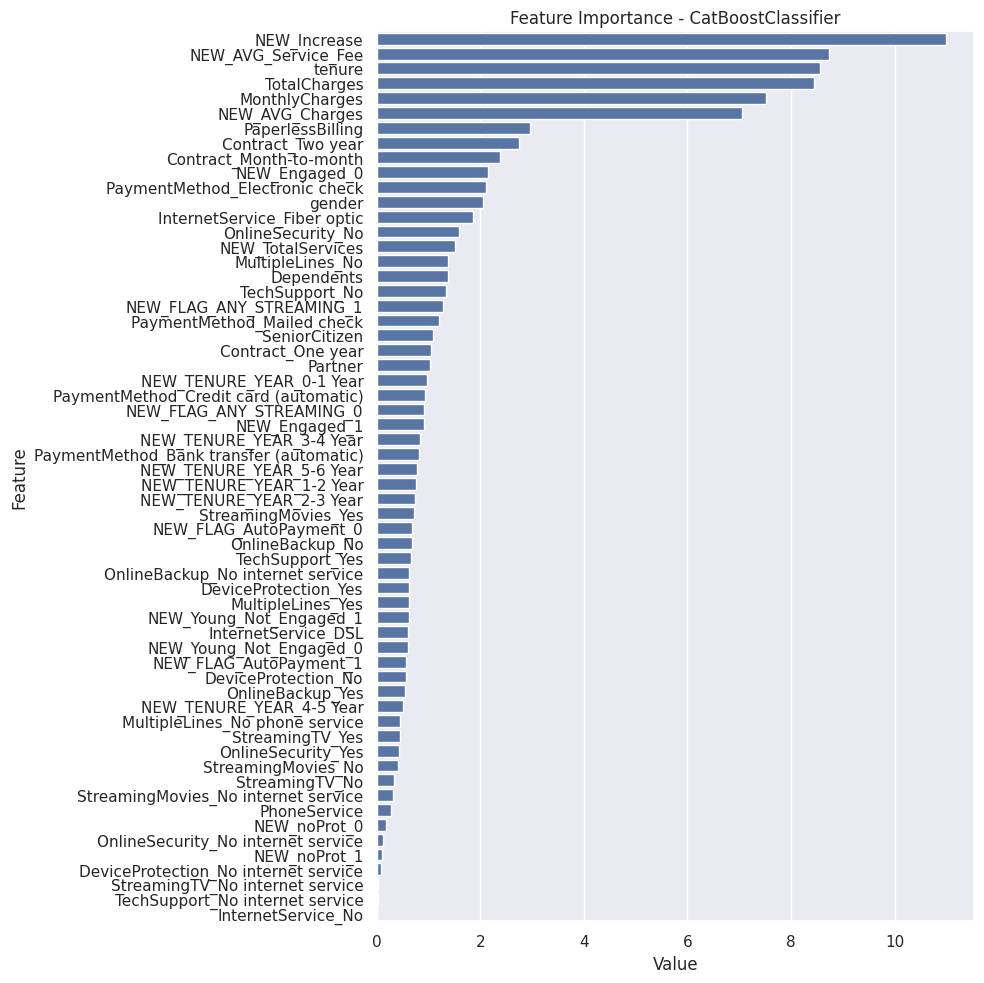

In [56]:
models = [RandomForestClassifier(),
              XGBClassifier(),
              LGBMClassifier(),
              CatBoostClassifier(verbose=False, random_state=12345)
              ]
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig(f'importances_{model.__class__.__name__}.png')
for model in models:
    model.fit(X, y)
    plot_importance(model, X)

**Comparison After Feature Engineering**

In [58]:
base_metrics = {
    "Model": ["LR", "KNN", "CART", "RF", "XGB", "LightGBM", "CatBoost"],
    "Accuracy": [base_models_metrics[0]['Accuracy'], base_models_metrics[1]['Accuracy'],
                 base_models_metrics[2]['Accuracy'], base_models_metrics[3]['Accuracy'],
                 base_models_metrics[4]['Accuracy'], base_models_metrics[5]['Accuracy'],
                 base_models_metrics[6]['Accuracy']],
    "AUC": [base_models_metrics[0]['AUC'], base_models_metrics[1]['AUC'],
            base_models_metrics[2]['AUC'], base_models_metrics[3]['AUC'],
            base_models_metrics[4]['AUC'], base_models_metrics[5]['AUC'],
            base_models_metrics[6]['AUC']],
    "Recall": [base_models_metrics[0]['Recall'], base_models_metrics[1]['Recall'],
               base_models_metrics[2]['Recall'], base_models_metrics[3]['Recall'],
               base_models_metrics[4]['Recall'], base_models_metrics[5]['Recall'],
               base_models_metrics[6]['Recall']],
    "Precision": [base_models_metrics[0]['Precision'], base_models_metrics[1]['Precision'],
                  base_models_metrics[2]['Precision'], base_models_metrics[3]['Precision'],
                  base_models_metrics[4]['Precision'], base_models_metrics[5]['Precision'],
                  base_models_metrics[6]['Precision']],
    "F1": [base_models_metrics[0]['F1'], base_models_metrics[1]['F1'],
           base_models_metrics[2]['F1'], base_models_metrics[3]['F1'],
           base_models_metrics[4]['F1'], base_models_metrics[5]['F1'],
           base_models_metrics[6]['F1']]
}

last_metrics = {
    "Model": ["LR", "KNN", "CART", "RF", "XGB", "LightGBM", "CatBoost"],
    "Accuracy": [last_models_metrics[0]['Accuracy'], last_models_metrics[1]['Accuracy'],
                 last_models_metrics[2]['Accuracy'], last_models_metrics[3]['Accuracy'],
                 last_models_metrics[4]['Accuracy'], last_models_metrics[5]['Accuracy'],
                 last_models_metrics[6]['Accuracy']],
    "AUC": [last_models_metrics[0]['AUC'], last_models_metrics[1]['AUC'],
            last_models_metrics[2]['AUC'], last_models_metrics[3]['AUC'],
            last_models_metrics[4]['AUC'], last_models_metrics[5]['AUC'],
            last_models_metrics[6]['AUC']],
    "Recall": [last_models_metrics[0]['Recall'], last_models_metrics[1]['Recall'],
               last_models_metrics[2]['Recall'], last_models_metrics[3]['Recall'],
               last_models_metrics[4]['Recall'], last_models_metrics[5]['Recall'],
               last_models_metrics[6]['Recall']],
    "Precision": [last_models_metrics[0]['Precision'], last_models_metrics[1]['Precision'],
                  last_models_metrics[2]['Precision'], last_models_metrics[3]['Precision'],
                  last_models_metrics[4]['Precision'], last_models_metrics[5]['Precision'],
                  last_models_metrics[6]['Precision']],
    "F1": [last_models_metrics[0]['F1'], last_models_metrics[1]['F1'],
           last_models_metrics[2]['F1'], last_models_metrics[3]['F1'],
           last_models_metrics[4]['F1'], last_models_metrics[5]['F1'],
           last_models_metrics[6]['F1']]
}

# Creating DataFrames from the metric dictionaries
base_results_df = pd.DataFrame(base_metrics)
last_results_df = pd.DataFrame(last_metrics)

# Calculating the improvement percentages for each metric
improvement_df = pd.DataFrame()
improvement_df["Model"] = base_results_df["Model"]
improvement_df["Accuracy"] = ((last_results_df["Accuracy"] - base_results_df["Accuracy"]) / base_results_df["Accuracy"]) * 100
improvement_df["AUC"] = ((last_results_df["AUC"] - base_results_df["AUC"]) / base_results_df["AUC"]) * 100
improvement_df["Recall"] = ((last_results_df["Recall"] - base_results_df["Recall"]) / base_results_df["Recall"]) * 100
improvement_df["Precision"] = ((last_results_df["Precision"] - base_results_df["Precision"]) / base_results_df["Precision"]) * 100
improvement_df["F1"] = ((last_results_df["F1"] - base_results_df["F1"]) / base_results_df["F1"]) * 100

# Sorting the DataFrame by accuracy improvement in descending order
improvement_df = improvement_df.sort_values(by="Accuracy", ascending=False)

# Creating the figure for the graph
fig = go.Figure()

# Adding traces for each metric in the specified order
for metric, color in zip(["Accuracy", "AUC", "Recall", "Precision", "F1"], colors):
    fig.add_trace(go.Bar(
        x=improvement_df["Model"],
        y=improvement_df[metric],
        marker_color=color,
        name=metric,
        text=improvement_df[metric].apply(lambda x: f"{round(x, 2)}%"),
        textposition='auto'
    ))

# Setting axis labels and title
fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Improvement Percentage",
    title="Comparison After Feature Engineering"
)

# Displaying the graph
fig.show(block=True)